# Import

In [1]:
import warnings
warnings.filterwarnings(action='once')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC #???????????????//
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, kendalltau

from astropy.table import QTable
from time import time

## Load required data

In [3]:
bounds = pickle.load(open('./pickle/bounds.pk','rb'))
master_cat = pd.read_csv('./catdata/master_catalog_jan_2023.csv')
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

C:\Users\jwarn\AppData\Local\Temp\ipykernel_19844\2776487076.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/bounds.pk'>
  bounds = pickle.load(open('./pickle/bounds.pk','rb'))


In [4]:
object_match_files = ['matches_delta006.pk','matches_delta005.pk','matches_delta004.pk']

# Training Data Generator

In [5]:
def load_cat(field): # change to match-case
    bounds = [50,100,150,200,235,257,279,320,360,406]
    for b in range(len(bounds)):
        if field <= bounds[b]:
            to_load = cat_files[b]
            break
    print(f'Loading {to_load} ...')
    catalogue = pickle.load(open(f'./pickle/{to_load}','rb'))
    return catalogue

In [6]:
# 23.01.26 18:29
def generate_training_data(matches, crowding=300) -> pd.DataFrame:
    cat = load_cat(1)
    
    columns = ['obj_id','class','i','g','di','dg','ra','dec','field','pdidx','rbcidx','nearby']
    values = []
    object_ids = []
    
    #TEMP
    crowded_objects = []
    
    
    for field in matches: # iterate through each field ID
        working_field = matches[field] # take the list of matches e.g. working_field = [(166727, 2642), (159637, 2646)]
        if field not in cat: # load the correct catalogue
            cat = load_cat(field)
        for m in working_field: # iterate through each match (a tuple) and grab values from catalogues
            
            if m[2] > crowding: # testing
                crowded_objects.append(m[1:])
                continue
            
            obj_id = master_cat.loc[m[1]].ID
            class_ = master_cat.loc[m[1]].CLASS
            
            if obj_id in object_ids: continue # if we've already added the object then skip
            else: object_ids.append(obj_id)   # else add it to the list of ids
            
            if class_ == 1: class_str = 'gc' # convert class numbers into strings
            elif class_ == 4: class_str = 'galaxy'
            elif class_ == 6: class_str = 'star'
            else: continue # skip non-gc/gal/stars
            
            # collect required data
            row = cat[field][m[0]]
            ra = row['RA']
            dec = row['Dec']
            g = row['g']
            i = row['i']
            dg = row['dg']
            di = row['di']
            
            values.append([obj_id,class_str,i,g,di,dg,ra,dec,field,m[0],m[1],m[2]])
    
    training_data_dict = dict(zip(columns,zip(*values))) # zip values and columns together into a dict (columns as keys)
    training_data_df = pd.DataFrame(training_data_dict) # put into pd Dataframe
    return training_data_df, crowded_objects

In [108]:
obj_mat = pickle.load(open(f'./pickle/matches/matches_delta005_0802.pk','rb'))

In [113]:
a

[(262, 221),
 (265, 208),
 (287, 201),
 (309, 202),
 (320, 212),
 (334, 234),
 (339, 220),
 (352, 218),
 (380, 202),
 (451, 202),
 (492, 202),
 (844, 207),
 (878, 219),
 (1037, 230),
 (1101, 239),
 (1123, 215),
 (1124, 211),
 (1128, 233),
 (1131, 217),
 (1132, 208),
 (1144, 254),
 (1150, 218),
 (1202, 207),
 (1222, 207),
 (1317, 224),
 (1323, 230),
 (1348, 222),
 (1452, 234),
 (1456, 252),
 (1459, 232),
 (1464, 225),
 (1465, 208),
 (1480, 242),
 (1499, 224),
 (1513, 218),
 (1544, 246),
 (1689, 202),
 (1823, 210),
 (1837, 203),
 (1862, 216),
 (1864, 201),
 (1897, 236),
 (1904, 207),
 (1984, 203),
 (1993, 212),
 (2038, 210),
 (514, 255),
 (515, 211),
 (518, 285),
 (519, 239),
 (521, 294),
 (525, 237),
 (531, 251),
 (536, 204),
 (540, 249),
 (425, 209),
 (448, 218),
 (461, 296),
 (487, 279),
 (489, 278),
 (491, 212),
 (496, 290),
 (506, 258),
 (510, 308),
 (2099, 204),
 (918, 203),
 (940, 205),
 (1103, 211),
 (1267, 214),
 (1402, 204),
 (1601, 203),
 (1715, 226),
 (1722, 204),
 (1727, 217

In [112]:
_, a = generate_training_data(obj_mat,crowding=200)

Loading cat1_50.pk ...
Loading cat51_100.pk ...
Loading cat101_150.pk ...
Loading cat151_200.pk ...
Loading cat201_235.pk ...
Loading cat236_257.pk ...
Loading cat258_279.pk ...
Loading cat280_320.pk ...
Loading cat321_360.pk ...
Loading cat361_406.pk ...


In [38]:
#generate training data for a range of crowding, and delta, values
object_match_files = ['matches_delta006.pk','matches_delta005.pk','matches_delta004.pk','matches_delta003.pk']
#TEMP
object_match_files = ['matches_delta005_0502.pk']

for m in object_match_files:
    obj_mat = pickle.load(open(f'./pickle/matches/{m}','rb'))
    #training_data = {}
    for c in crowding_test_values[0:1]:
        print(c)
        training_data, _ = generate_training_data(obj_mat, crowding=c)
    with open(f'./pickle/training_data/training_data_0502.pk','wb') as f: #m[-4:-3] = the delta number
        pickle.dump(training_data,f)

300


To filter the training data for different crowding values, we can simply iterate back through the list of matches and remove the entries that are outside the threshold, instead of having to re-generate the data every time.

# Statistics

In [7]:
def calc_correlations(pred,true):
    correlations = {}
    correlations['mse'] = mean_squared_error(pred,true)
    correlations['ktau'] = kendalltau(pred,true)[0]
    correlations['pval-ktau'] = kendalltau(pred,true)[1]
    correlations['pearsonr'] = pearsonr(pred,true)[0]
    correlations['pval-pearsonr'] = pearsonr(pred,true)[1]
    correlations['r2'] = r2_score(true, pred)
    return correlations

In [8]:
def pretty_corr(c): # pretty print output from calc_correlations()
    print(f"""
    Mean squared error (RMS): \t{c['mse']:.5f}\t({(c['mse']**.5):.5})
    Kendall Tau: \t\t{c['ktau']:.5}
    \tKtau p-value: \t\t{c['pval-ktau']:.5}
    Pearson's r: \t\t{c['pearsonr']:.5}
    \tPearson's r p-value: \t{c['pval-pearsonr']:.5}
    Coef. of determination \t{c['r2']:.5}
    """)

# Random Forest

In [142]:
def ranfor(df,train_size=0.8,n_estimators=50,criterion='gini',features=['i','g'], max_depth=None, max_leaf_nodes=None, stats=False, scale=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split the data
    if scale:
        # scale the data
        scaler = preprocessing.StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size) # X
    # train the regressor model
    ran_for_class = RandomForestClassifier(n_estimators=n_estimators,
                                    criterion=criterion
                                   ).fit(X_train,y_train)
    pred = ran_for_class.predict(X_test)
    
    acc = ran_for_class.score(X_test,y_test)
    
    true = y_test.to_numpy()
    if stats:
        return ran_for_class, pred, true
    else: return ran_for_class

In [191]:
cat_candidate

RA,Dec,iccd,xg,yg,g,dg,ig,xi,yi,i,di,ii,ia,field
float32,float32,uint8,float32,float32,float32,float32,int8,float32,float32,float32,float32,int8,int8,uint16
19.14174,40.27077,1,660.97,4000.82,19.421,0.002,1,729.49,3880.86,18.127,0.001,1,0,222
19.101412,40.41592,1,64.58,1177.77,20.11,0.003,1,133.73,1057.34,18.677,0.002,1,0,222
19.200684,40.32258,1,1540.97,2980.66,20.338,0.003,1,1609.54,2860.92,19.396,0.003,1,0,222
19.097942,40.235348,1,9.05,4696.1,20.369,0.003,1,77.56,4575.86,19.416,0.003,1,0,222
19.112083,40.40053,1,222.64,1476.76,20.435,0.003,1,291.71,1356.46,18.941,0.002,1,0,222
19.108576,40.41003,1,170.9,1291.59,20.485,0.003,1,240.01,1171.29,19.822,0.003,1,0,222
19.171488,40.466434,1,1112.11,171.65,20.486,0.003,1,1181.32,51.5,22.187,0.017,1,0,222
19.125254,40.238495,1,415.46,4630.69,20.527,0.003,1,483.91,4510.6,19.71,0.003,1,0,222
19.17554,40.410896,1,1168.96,1260.16,20.699,0.003,1,1237.94,1140.18,20.054,0.004,1,0,222


In [192]:
def rf_pred(field,train,crowding=250,scale=False):
    training_data_ = train[train['nearby'] <= crowding]
    cat = load_cat(field)[field]
    
    # drop rows with high delta g/i values
    cat_d = cat[cat['dg']+cat['di'] < 0.05]
    # drop stars & saturated points
    cat_candidate = cat_d[(cat_d['ig'] == 1) & (cat_d['ii'] == 1)]
    
    X = cat_candidate[['i','g']]
    X = X.to_pandas()
    if scale:
        X_scaled = preprocessing.StandardScaler().fit(X).transform(X)
        res = ranfor(training_data_, n_estimators=60,scale=True).predict(X_scaled)
    else:
        res = ranfor(training_data_, n_estimators=60).predict(X)
    
    cat_pred = cat_candidate[['RA','Dec','iccd','xg','yg','g','dg','ig','xi','yi','i','di','ii','field']]
    cat_pred['pred'] = res
    return cat_pred

# SVC

In [143]:
def svc_class(df,train_size=0.8,max_iter=1000,loss='squared_hinge',features=['i','g'], stats=False, scale=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split the data
    if scale:
        # scale the data
        scaler = preprocessing.StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size) # X
    # train the regressor model
    svc_classifier = LinearSVC(dual=False,C=0.8,max_iter=max_iter).fit(X_train,y_train)
    pred = svc_classifier.predict(X_test)
    
    true = y_test.to_numpy()
    if stats:
        return svc_classifier, pred, true
    else: return svc_classifier

# MLP

Has trouble with suddenly predicting all the same value for every object

In [144]:
def mlp_class(df,train_size=0.8,hidden_layer_sizes=(10,),activation='relu',alpha=0.0001,max_iter=500,features=['i','g'], stats=False, scale=False):
    # select features for training
    X = df[features]
    y = df['class']
    # split the data
    if scale:
        # scale the data
        scaler = preprocessing.StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=train_size) # X_scaled
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size) # X
    # train the regressor model
    mlp_classifier = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                                   activation=activation, alpha=alpha, max_iter=max_iter,
                                   learning_rate='adaptive',early_stopping=True,
                                  ).fit(X_train,y_train)
    pred = mlp_classifier.predict(X_test)
    true = y_test.to_numpy()
    if stats:
        return mlp_classifier, pred, true
    else: return mlp_classifier

## Predictions

#### 08/02/2023

Automate training

In [13]:
train_file = 'training_data_0802.pk'

In [14]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [17]:
training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))
training_data_nostar = training_data[training_data['class'] != 'star']

C:\Users\jwarn\AppData\Local\Temp\ipykernel_19844\3009024223.py:1: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/training_data/training_data_0802.pk'>
  training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))


In [178]:
#RF

rf_classifier, pred, true = ranfor(training_data_nostar,n_estimators=50,max_depth=5, max_leaf_nodes=3,  stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'recall:{recall}\nprecision:{precision}\naccuracy:{accuracy}')

recall:0.848
precision:0.7851851851851852
accuracy:0.8346153846153846


In [212]:
field = 222
#RF
predictions_rf = rf_pred(field,training_data_nostar,crowding=300)
#with open(f'pickle/temp/predictionsf{field}.pk','wb') as f:
    #pickle.dump(predictions,f)
len(predictions_rf[predictions_rf['pred'] == 'gc'])

Loading cat201_235.pk ...


C:\Users\jwarn\AppData\Local\Temp\ipykernel_19844\2525829327.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/cat201_235.pk'>
  catalogue = pickle.load(open(f'./pickle/{to_load}','rb'))


2061

In [198]:
#SVC

svc_classifier, pred, true = svc_class(training_data_nostar, stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn)
recall

0.6946107784431138

#MLP

mlp_classifier, pred, true = mlp_class(training_data_nostar,hidden_layer_sizes=(20,),activation='logistic',alpha=0.0001, stats=True)

tn, fp, fn, tp = confusion_matrix(true,pred,labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn) # fraction of correctly identified GCs, out of all GCs (1-recall = fraction that were missed)
accuracy = (tp+tn)/(tp+fp+fn+tp) # fraction of correctly identified objects
precision = tp/(tp+fp) # fraction of correctly identified GCs, out of what were thought to be GCs
print(f'recall:{recall}\nprecision:{precision}\naccuracy:{accuracy}')

In [223]:
with open(f'pickle/temp/predictionsf222_0802test.pk','wb') as f:
    pickle.dump(predictions,f)

#### 05/02/2023

In [140]:
x = range(1,300,1)

In [148]:
y = [ len(training_data[training_data['nearby'] <= i]) for i in x ]

In [146]:
y = [ len(training_data_nostar[training_data_nostar['nearby'] <= i]) for i in x ]

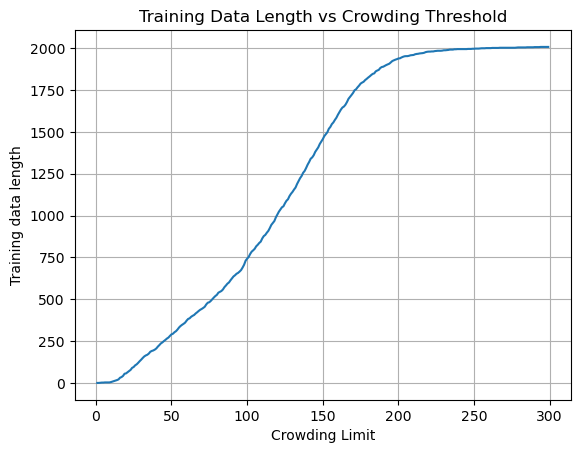

In [149]:
plt.plot(x,y)
plt.xlabel('Crowding Limit')
plt.ylabel('Training data length')
plt.title('Training Data Length vs Crowding Threshold')
plt.grid()

In [14]:
train_file = 'training_data_0502.pk'

In [11]:
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

In [15]:
training_data = pickle.load(open(f'./pickle/training_data/{train_file}','rb'))

In [16]:
training_data_nostar = training_data[training_data['class'] != 'star']

In [17]:
training_data_nostar

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby
0,HM33-A,gc,21.163000,22.052999,0.009,0.009,23.924183,28.820591,5,39696,2647,49
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12
...,...,...,...,...,...,...,...,...,...,...,...,...
2223,FJJ-IV,gc,18.417999,19.346001,0.002,0.002,9.801158,48.380100,398,168491,369,167
2224,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106
2225,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156
2226,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163


In [105]:
stats = ranfor(training_data_nostar,train_size=0.8, n_estimators=5, stats=True, max_depth=8, max_leaf_nodes=5)
stats[2]

0.7737704918032787

In [107]:
tn, fp, fn, tp = confusion_matrix(stats[1],stats[0],labels=['galaxy','gc']).ravel()

recall = tp/(tp+fn)
recall

0.75

In [389]:
rf_model  = ranfor(training_data_star, n_estimators=100)

#### Testing filtering the catalogues for prediction

In [205]:
cat = load_cat(26)[26].to_pandas()

In [213]:
cat_d = cat[cat['dg']+cat['di'] < 0.05]

In [231]:
cat_candidate = cat_d[~((cat_d['ig'] == -1) | (cat_d['ii'] == -1) | (cat_d['ig'] == -9) | (cat_d['ii'] == -9))] # drop stars & saturated points

#### Testing making predictions

In [83]:
test_ = predictions[~((predictions['ig'] == -1) | (predictions['ii'] == -1) )]

In [85]:
len(test_[test_['pred']=='gc'])

2487

In [236]:
field = 208
#RF
predictions = rf_pred(field,training_data_nostar,crowding=300)
with open(f'pickle/temp/predictionsf{field}1102.pk','wb') as f:
    pickle.dump(predictions,f)
len(predictions[predictions['pred'] == 'gc'])

Loading cat201_235.pk ...


C:\Users\jwarn\AppData\Local\Temp\ipykernel_19844\2525829327.py:8: ResourceWarning: unclosed file <_io.BufferedReader name='./pickle/cat201_235.pk'>
  catalogue = pickle.load(open(f'./pickle/{to_load}','rb'))


1488

In [222]:
gcs = predictions[predictions['pred']=='gc']

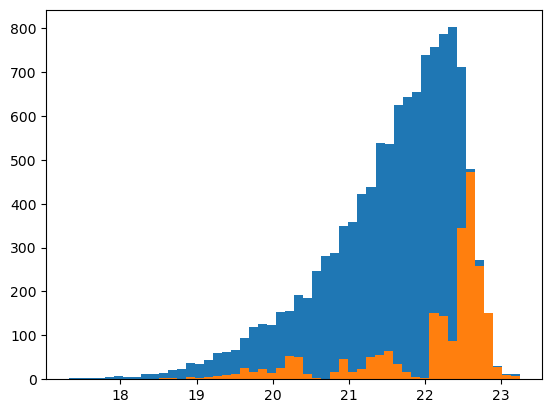

In [232]:
gcs = predictions[predictions['pred']=='gc']
gcs_44 = gcs#[(gcs['g']+gcs['i']<44) & (gcs['g']+gcs['i'] > 30)]

plt.hist(predictions['i'],bins=50)
plt.hist(gcs['i'],bins=50)

plt.show()


### Test

In [29]:
training_data_MAIN = pickle.load(open(f'./pickle/training_data/{train_files[0]}','rb'))

training_data = training_data_MAIN[300]

test_data = training_data[training_data['di']+training_data['dg'] < 0.1][training_data['class'] != 'star']

test_gcs = test_data[test_data['class'] == 'gc']

test_data

C:\Users\jwarn\AppData\Local\Temp\ipykernel_16988\1346209107.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_data = training_data[training_data['di']+training_data['dg'] < 0.1][training_data['class'] != 'star']


,obj_id,class,i,g,di,dg,ra,dec,field,pdidx
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860
...,...,...,...,...,...,...,...,...,...,...
2288,FJJ-VIII,gc,17.910999,18.806000,0.001,0.001,9.848991,48.312565,398,168456
2289,FJJ-IV,gc,18.417999,19.346001,0.002,0.002,9.801158,48.380100,398,168491
2290,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376
2291,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423


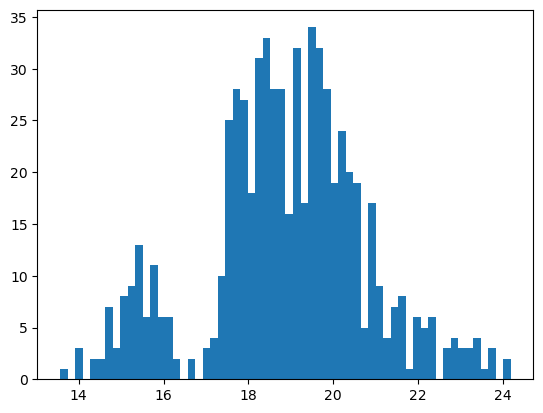

In [32]:
plt.hist(test_gcs['g'],bins=60)
plt.show()

In [ ]:
results = []
for 

In [ ]:
results = []
for file_name in train_files:
    training_data = pickle.load(open(f'./pickle/training_data/{file_name}','rb'))
    test_data = pickle.load(open(f'./pickle/{cat_files[3]}','rb'))[184] # field 184
    results.append(ranfor(training_data[250]).predict(test_data))

In [43]:
CAT = load_cat(188)

In [68]:
cat = CAT[188]

In [79]:
cat_smalldelta = cat[cat['dg']+cat['di'] < 0.1]

In [80]:
X = cat_smalldelta[['i','g']]

In [81]:
X = X.to_pandas()

In [82]:
X

,i,g
0,13.206000,13.678000
1,13.272000,13.694000
2,13.528000,13.924000
3,13.246000,13.950000
4,13.625000,13.929000
...,...,...
53345,21.943001,24.875999
53346,21.957001,24.913000
53347,21.662001,24.964001
53348,21.547001,24.981001


In [125]:
f = ['training_data_d006.pk','training_data_d005.pk','training_data_d004.pk','training_data_d003.pk']

In [126]:
training_data = pickle.load(open(f'./pickle/training_data/{f[1]}','rb'))

In [93]:
test_results = ranfor(test_, n_estimators=70, stats=True)

In [95]:
predictions188 = ranfor(test_, n_estimators=60).predict(X)

In [94]:
test_results[2] # yay!

0.8382352941176471

In [105]:
cat_smalldelta['pred'] = predictions188

In [100]:
cat395_pred = cat[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [101]:
cat395_pred['pred'] = res

In [103]:
with open('./pickle/ml_results/field395_predictions.pk','wb') as f:
    pickle.dump(cat395_pred,f)

In [84]:
test_ = pickle.load(open('./pickle/ml_results/field273_predictions.pk','rb'))

In [128]:
cat188_pred = cat[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [129]:
cat188_pred['pred'] = res

In [130]:
with open('./pickle/ml_results/field188_predictions.pk','wb') as f:
    pickle.dump(cat188_pred,f)

In [115]:
cat24_pred = cat24[['RA','Dec','iccd','xg','yg','g','ig','xi','yi','i','ii','field']]

In [116]:
cat24_pred['pred'] = res

In [117]:
with open('./pickle/ml_results/field24_predictions.pk','wb') as f:
    pickle.dump(cat24_pred,f)

In [53]:
# iterate to find best values
crowding_test_values = [300,275,250,225,200,175,150,125,100,75,50]
trees = [10,25,50,60,80,120]
accuracies = {}
iterations = 3

for m in object_match_files:
    obj_mat = pickle.load(open(f'./pickle/matches/{m}','rb'))
    accuracies[m[-4:-3]] = []
    for c in trees:#crowding_test_values:
        acc_t = 0 # total accuracy sum
        for i in range(iterations):
            t1 = time()
            #training_data, _ = generate_training_data(obj_mat, crowding=250) #stupid!
            _, __, acc = ranfor(training_data, n_estimators=c)
            acc_t += acc
            t2 = time()
            print(t2-t1)
        acc_t /= iterations
        accuracies[m[-4:-3]].append(acc_t)
        print(f'crowding: {c}, accuracy: {acc_t}')
        

59.16055750846863
55.01980996131897
53.677734375
crowding: 300, accuracy: 0.6144170295113692
51.2863883972168
54.201602935791016
66.1094582080841
crowding: 275, accuracy: 0.6368604073522107
77.24949383735657
71.25472140312195
73.84445881843567
crowding: 250, accuracy: 0.60671834625323
67.04550671577454
55.90899848937988
55.41255736351013
crowding: 225, accuracy: 0.6017094017094017
52.776262044906616
52.33641076087952


KeyboardInterrupt: 

In [ ]:
with open('./pickle/ml_results/accuracies_d00654_300-50--25.pk','wb') as f:
    pickle.dump(accuracies,f)

In [ ]:
#d005
plt.plot(crowding_test_values, accuracies[4], 'g')
plt.plot(crowding_test_values, accuracies[5], 'b')
plt.plot(crowding_test_values, accuracies[6], 'r')

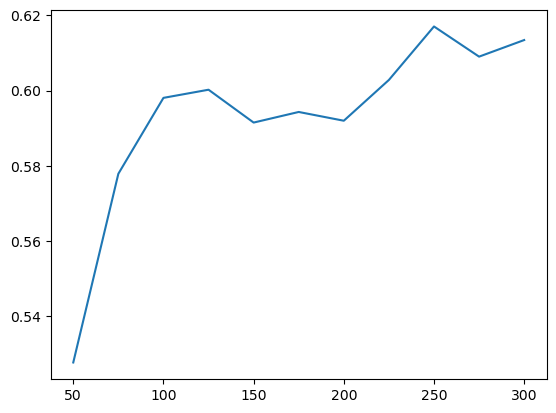

In [39]:
#d006
plt.plot(crowding_test_values, accuracies)